In [79]:
""" Imports """

import math
import numpy as np
import random as rnd
import matplotlib.pyplot as plt

plt.style.use("seaborn")

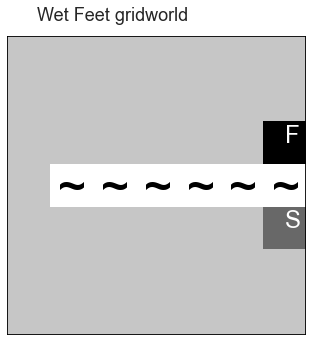

In [355]:
""" Grid world physics"""

SIZE_Y, SIZE_X = (7, 7)
WORLD = np.zeros((SIZE_Y, SIZE_X))
WORLD[[4,2], -1] = 1, 2
WORLD[3, 1:] = -1

ACTION_SPACE = {
    0: (0,1),  # RIGHT
    1: (1,0),  # DOWN
    2: (0,-1), # LEFT
    3: (-1,0)  # UP
}

direction = lambda s, a: (s[0]+a[0], s[1]+a[1])
is_legal = lambda m: (m[0]>=0 and m[0]<SIZE_Y) and (m[1]>=0 and m[1]<SIZE_X)

REWARD = {0:0, 1:0, 2: 1, -1: -1}

draw_world("Wet Feet gridworld")

In [353]:
def canvas_plot(ax=None) -> None:
    """ Border around gridworld using globals: SIZE X & Y """
    ax.hlines(-.5,       -.5, SIZE_X-.5, colors="k")
    ax.hlines(SIZE_Y-.5, -.5, SIZE_X-.5, colors="k")
    ax.vlines(-.5,       -.5, SIZE_Y-.5, colors="k")
    ax.vlines(SIZE_X-.5, -.5, SIZE_Y-.5, colors="k")
    

def draw_world(title="", annotated=True, show=False, ax=None):
    """ Needlessly fancy Gridworld plotter with outlines and annotations """
    if ax==None: fig, ax = plt.subplots()
        
    ax.imshow(WORLD)
    ax.set_axis_off()
    ax.text(.1, 1.05, title, transform=ax.transAxes, fontdict={"size":18})
    
    canvas_plot(ax)
    if annotated: # OOP scriptable object here!
        # Render Start "S"
        ax.text(*reversed(np.where(WORLD==1)), "S", 
                 fontdict={"size": 24}, c="w")
        # Render Finish "F"
        ax.text(*reversed(np.where(WORLD==2)), "F", 
                 fontdict={"size": 24}, c="w") 
        # Render Water "~"
        for x, y in list(zip(*reversed(np.where(WORLD==-1)))):
            ax.text(x-.3, y+.4, "~", fontdict={"size": 48}, c="k")
    
    if show: plt.show()

    
def draw_quality(Q:np.ndarray, action=0, ax=None) -> None:
    """ Single action value map """
    ax.imshow(Q[..., action])
    canvas_plot(ax)
    
def visual_policy(Q:np.ndarray, title="", allowed=[], ax=None) -> None:
    """ Plots gridworld with arrows indicating states' greedy action """
    if ax==None: fig, ax = plt.subplots()
    draw_world(title, annotated=False, show=False, ax=ax)
    for (y,x), val in np.ndenumerate(np.argmax(Q, -1)):
        if WORLD[y,x] in allowed: draw_arrow(val, (y,x), ax=ax)

ARROWS = {
    # RIGHT
    0: [[(0,0),(0,.4)],
        [(.1,0),(.2,.4)],
        [(-.1,0),(.2,.4)]],
    # DOWN
    1: [[(0,.4),(0,0)],
        [(.4,.2),(0,.1)],
        [(.4,.2),(0,-.1)]],
    # LEFT
    2: [[(0,0),(0,-.4)],
        [(.1,0),(-.2,-.4)],
        [(-.1,0),(-.2,-.4)]],
    # UP
    3: [[(0,-.4),(0,0)],
        [(-.4,-.2),(0,.1)],
        [(-.4,-.2),(0,-.1)]],
}
offset = lambda point, val: (point[0]+val, point[1]+val)
def draw_arrow(direction:int, position:tuple, color="r", ax=None) -> None:
    """ Arrow representing states'(position) greedy action(direction) """
    x = list(map(lambda arrow: offset(arrow, position[0]), list(zip(*ARROWS[direction]))[0]))
    y = list(map(lambda arrow: offset(arrow, position[1]), list(zip(*ARROWS[direction]))[1]))
    [ax.plot(*line, c=color) for line in list(zip(y, x))]
    
def detailed_quality_check(Q:np.ndarray, title="", allowed=[]) -> None:
    """ Policy on top of world in the center, every direction is the value map of that action """
    fig, axis = plt.subplots(3, 3, figsize=(15, 15))
    axis[0,1].text(0, 1.1, title, transform=axis[0,1].transAxes, fontdict={"size":32})
    
    [ax.set_axis_off() for ax in axis.flatten()]
    action_axes = [axis[1,2], axis[2,1], axis[1,0], axis[0,1]]
    visual_policy(Q, allowed=allowed, ax=axis[1,1])
    for idx, ax in enumerate(action_axes):
        draw_quality(Q, idx, ax)
        argmax = np.argmax(Q, -1)
        for (y,x), val in np.ndenumerate(np.argmax(Q, -1)):
            if argmax[y,x] == idx: draw_arrow(val, (y,x), ax=ax)
    

# One-step learning algorithm recap

In [318]:
""" Hyper parameters """

ALPHA = 2e-3
EPSIL = 0.66
GAMMA = 0.99

NUM_GAMES = int(1e5)


def policy(A:np.ndarray, state:tuple, eps=0.66) -> int:
    """ Select max action for passed state with epsilon chance at random action """
    if 1-eps < rnd.random(): 
        return rnd.choice(list(ACTION_SPACE))
    return np.argmax(A[state])


def temporal_difference(V:np.ndarray, s, r, s_) -> float:
    """ Simple value update from state to state, receiving reward """
    curr_v, next_v = V[s], V[s_]
    
    return curr_v + ALPHA * (r + GAMMA * next_v - curr_v)


def sarsa(Q:np.ndarray, s, a, r, s_, a_) -> float:
    """ Step update from state, action, reward, resulting state and follow-up action"""
    """ On-policy value function based on state-action transition and next action"""
    curr_sa, next_sa = Q[s][a], Q[s_][a_]
    
    return curr_sa + ALPHA * (r + GAMMA * next_sa - curr_sa)


def expected_sarsa(Q:np.ndarray, s, a, r, s_) -> float:
    """ Value function based on state-action transition and sum over greedy next actions """
    curr_sa = Q[s][a]
    max_val = np.max(Q[s_])
    expected = sum(
        Q[s_][a_]
        for a_ in ACTION_SPACE
        if Q[s_][a_] == max_val
    )
    return curr_sa + ALPHA * (r + GAMMA * expected - curr_sa)


def q_learning(Q:np.ndarray, s, a, r, s_) -> float:
    """ Off-policy value function based on state-action transition & max next action-val """
    curr_sa = Q[s][a]
    max_a = max(Q[s_][a_] for a_ in ACTION_SPACE)
    
    return curr_sa + ALPHA * (r + (GAMMA * max_a) - curr_sa)


def double_q_learning(Q_a, Q_b, s, a, r, s_) -> float:
    """ Variation on Q-learning with 2 alternating state-action maps 
        This eliminates the Maximization Bias """
    curr_sa = Q_a[s][a]
    a_ = np.argmax(Q_a[s_])
    next_sa = Q_b[s_][a_]
    
    return curr_sa + ALPHA * (r + (GAMMA * next_sa) - curr_sa)

State-action value optimization is 10% done.
State-action value optimization is 20% done.
State-action value optimization is 30% done.
State-action value optimization is 40% done.
State-action value optimization is 50% done.
State-action value optimization is 60% done.
State-action value optimization is 70% done.
State-action value optimization is 80% done.
State-action value optimization is 90% done.
State-action value optimization is 100% done.


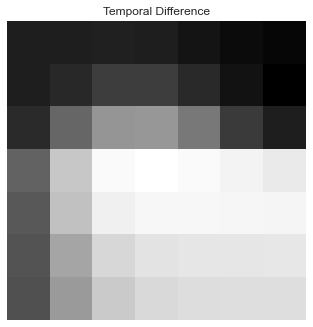

In [319]:
""" Temporal Difference """

state_value = np.zeros((SIZE_Y, SIZE_X))

for episode in range(1, NUM_GAMES+1):
    state = tuple(map(int, np.where(WORLD==1)))
    while state != np.where(WORLD==2):
        action = policy(state_value, state, EPSIL)
        move = direction(state, ACTION_SPACE[action])
        next_s = move if is_legal(move) else state
        reward = REWARD[WORLD[next_s]]

        state_value[state] = temporal_difference(state_value, state, reward, next_s)
        state = next_s
        
    if episode % (NUM_GAMES//10) == 0:
        print(f"State-action value optimization is {episode / NUM_GAMES:.0%} done.")
        
plt.imshow(state_value); plt.title("Temporal Difference"); 
plt.gca().set_axis_off(); plt.show()

State-action value optimization is 10% done.
State-action value optimization is 20% done.
State-action value optimization is 30% done.
State-action value optimization is 40% done.
State-action value optimization is 50% done.
State-action value optimization is 60% done.
State-action value optimization is 70% done.
State-action value optimization is 80% done.
State-action value optimization is 90% done.
State-action value optimization is 100% done.


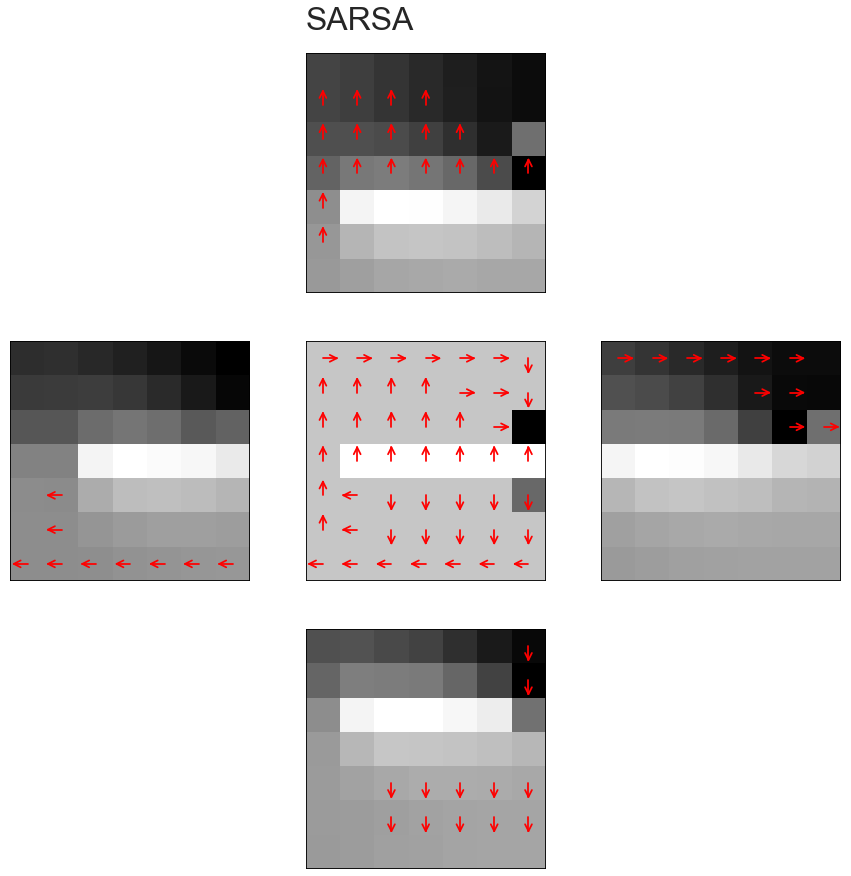

In [320]:
""" SARSA """

Q = np.zeros((SIZE_Y, SIZE_X, len(ACTION_SPACE)))

for episode in range(1, NUM_GAMES+1):
    state = tuple(map(int, np.where(WORLD==1)))
    action = policy(Q, state, EPSIL)
    while state != np.where(WORLD==2):
        move = direction(state, ACTION_SPACE[action])
        next_s = move if is_legal(move) else state
        next_a = policy(Q, next_s, EPSIL)
        reward = REWARD[WORLD[next_s]]

        Q[state][action] = sarsa(Q, state, action, reward, next_s, next_a)
        state, action = next_s, next_a
        
    if episode % (NUM_GAMES//10) == 0:
        print(f"State-action value optimization is {episode / NUM_GAMES:.0%} done.")
        
detailed_quality_check(state_action_value, "SARSA", [-1,0,1])

State-action value optimization is 10% done.
State-action value optimization is 20% done.
State-action value optimization is 30% done.
State-action value optimization is 40% done.
State-action value optimization is 50% done.
State-action value optimization is 60% done.
State-action value optimization is 70% done.
State-action value optimization is 80% done.
State-action value optimization is 90% done.
State-action value optimization is 100% done.


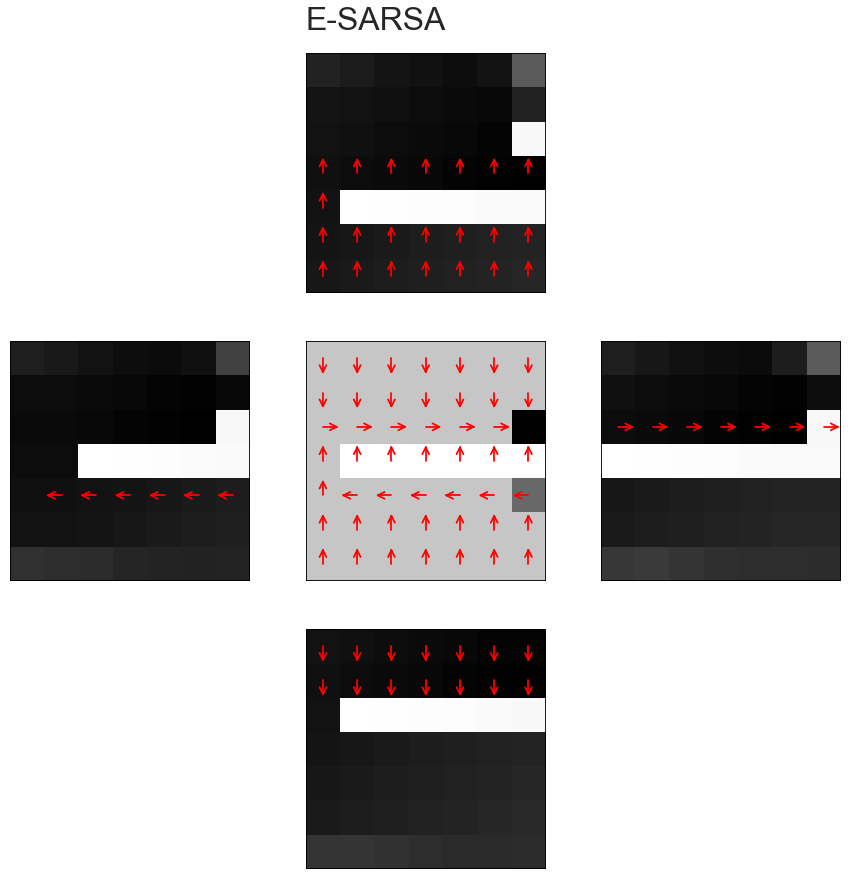

In [297]:
""" Expected SARSA """

Q = np.zeros((SIZE_Y, SIZE_X, len(ACTION_SPACE)))

for episode in range(1, NUM_GAMES+1):
    state = tuple(map(int, np.where(WORLD==1)))
    while state != np.where(WORLD==2):
        action = policy(Q, state, EPSIL)
        move = direction(state, ACTION_SPACE[action])
        next_s = move if is_legal(move) else state
        reward = REWARD[WORLD[next_s]]

        Q[state][action] = expected_sarsa(Q, state, action, reward, next_s)
        state = next_s  
                
    if episode % (NUM_GAMES//10) == 0:
        print(f"State-action value optimization is {episode / NUM_GAMES:.0%} done.")
        
detailed_quality_check(Q, "E-SARSA", [-1,0,1])

State-action value optimization is 10% done.
State-action value optimization is 20% done.
State-action value optimization is 30% done.
State-action value optimization is 40% done.
State-action value optimization is 50% done.
State-action value optimization is 60% done.
State-action value optimization is 70% done.
State-action value optimization is 80% done.
State-action value optimization is 90% done.
State-action value optimization is 100% done.


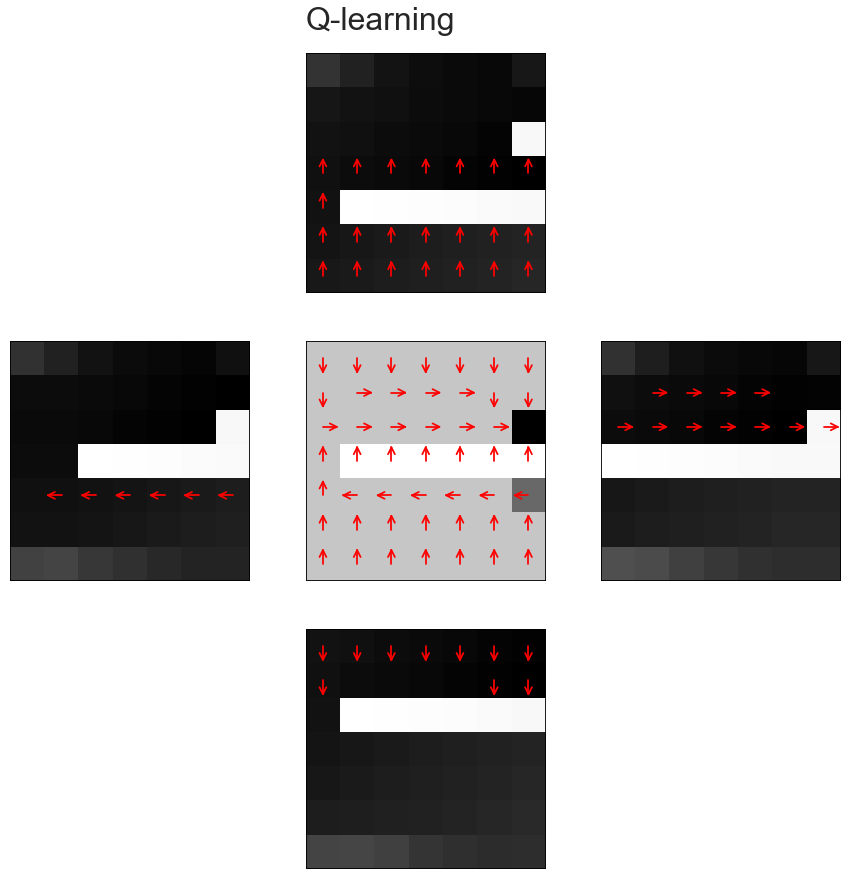

In [298]:
""" Q-learning """

Q = np.zeros((SIZE_Y, SIZE_X, len(ACTION_SPACE)))

for episode in range(1, NUM_GAMES+1):
    state = tuple(map(int, np.where(WORLD==1)))
    while state != np.where(WORLD==2):
        action = policy(Q, state, EPSIL)
        move = direction(state, ACTION_SPACE[action])
        next_s = move if is_legal(move) else state
        reward = REWARD[WORLD[next_s]]

        Q[state][action] = q_learning(Q, state, action, reward, next_s)
        state = next_s     
        
    if episode % (NUM_GAMES//10) == 0:
        print(f"State-action value optimization is {episode / NUM_GAMES:.0%} done.")
        
detailed_quality_check(Q, "Q-learning", [-1,0,1])

State-action value optimization is 10% done.
State-action value optimization is 20% done.
State-action value optimization is 30% done.
State-action value optimization is 40% done.
State-action value optimization is 50% done.
State-action value optimization is 60% done.
State-action value optimization is 70% done.
State-action value optimization is 80% done.
State-action value optimization is 90% done.
State-action value optimization is 100% done.


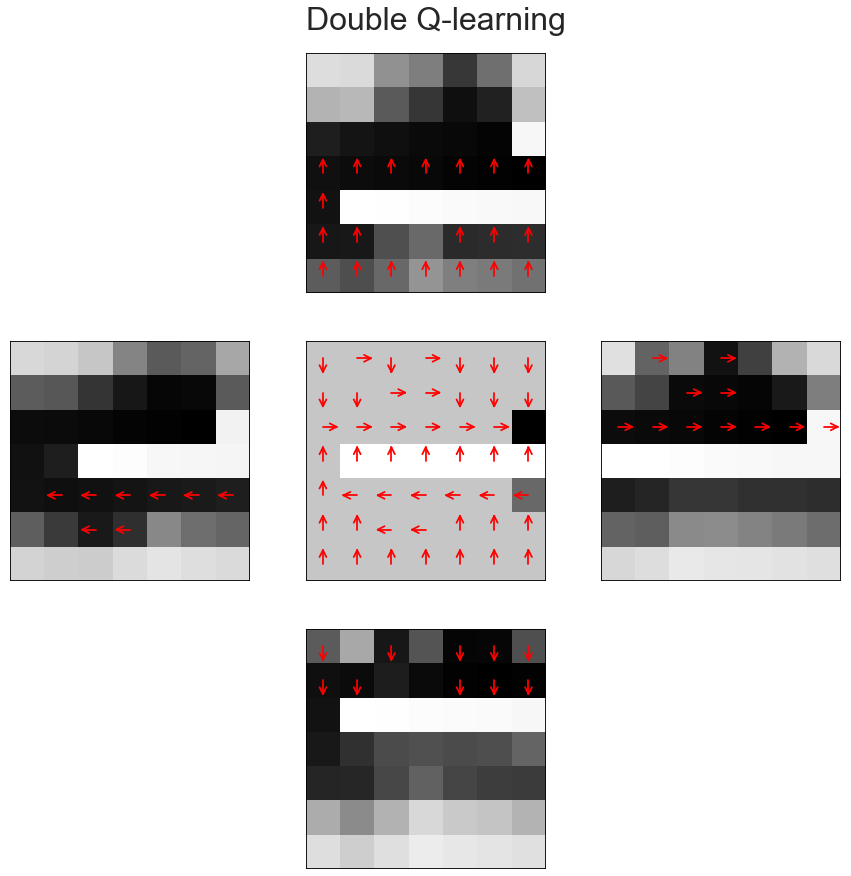

In [299]:
""" Double Q-learning """

Q_a = np.zeros((SIZE_Y, SIZE_X, len(ACTION_SPACE)))
Q_b = np.zeros((SIZE_Y, SIZE_X, len(ACTION_SPACE)))

for episode in range(1, NUM_GAMES+1):
    state = tuple(map(int, np.where(WORLD==1)))
    while state != np.where(WORLD==2):
        action = policy(Q_a + Q_b, state, EPSIL)
        move = direction(state, ACTION_SPACE[action])
        next_s = move if is_legal(move) else state
        reward = REWARD[WORLD[next_s]]

        if rnd.random() > 0.5:
            Q_a[state][action] = double_q_learning(Q_a, Q_b, state, action, reward, next_s)
        else:
            Q_b[state][action] = double_q_learning(Q_b, Q_a, state, action, reward, next_s)
            
        state = next_s     
        
    if episode % (NUM_GAMES//10) == 0:
        print(f"State-action value optimization is {episode / NUM_GAMES:.0%} done.")
        
detailed_quality_check(Q_a + Q_b, "Double Q-learning", [-1,0,1])

# N-step TD for estimating $V\approx v_\pi$

Reinforcement Learning: An Introduction 7.1: n-step TD prediction (page 144)

State-action value optimization is 0% done.


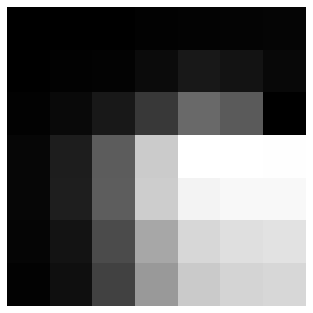

In [331]:
horizon = 4

state_value = np.zeros((SIZE_Y, SIZE_X))

for episode in range(int(5e3)):
    state = tuple(map(int, np.where(WORLD==1)))
    states, rewards = [state], [0]
    
    step = 0
    terminal = float("inf")
    
    while True:
        if step < terminal:
            action = policy(state_value, state, EPSIL)
            move = direction(state, ACTION_SPACE[action])
            next_s = move if is_legal(move) else state
            
            states.append(next_s)
            rewards.append(REWARD[WORLD[next_s]])
            
            if next_s == np.where(WORLD==2):
                terminal = step +1
                
            state = next_s
            
        tau = step - horizon + 1
        if tau >= 0:
            expected = sum( # return_tau : tau+n
                GAMMA **(i-tau-1) *rewards[i] 
                for i in range(tau+1, min(tau+horizon, terminal))
            )
            
            if tau + horizon < terminal:
                expected += GAMMA **horizon *state_value[states[tau+horizon]]    
            state_value[states[tau]] += ALPHA*(expected - state_value[states[tau]])
        
        if tau == terminal - 1: break
        step += 1
        
    if episode % (NUM_GAMES//10) == 0:
        print(f"State-action value optimization is {episode / NUM_GAMES:.0%} done.")
        
plt.imshow(state_value)
plt.gca().set_axis_off()
plt.show()

# N-step Sarsa for estimating $Q\approx q_*$ or $q_\pi$

Reinforcement Learning: An Introduction 7.2: n-step Sarsa (page 147)

State-action value optimization is 10% done.
State-action value optimization is 20% done.
State-action value optimization is 30% done.
State-action value optimization is 40% done.
State-action value optimization is 50% done.
State-action value optimization is 60% done.
State-action value optimization is 70% done.
State-action value optimization is 80% done.
State-action value optimization is 90% done.
State-action value optimization is 100% done.


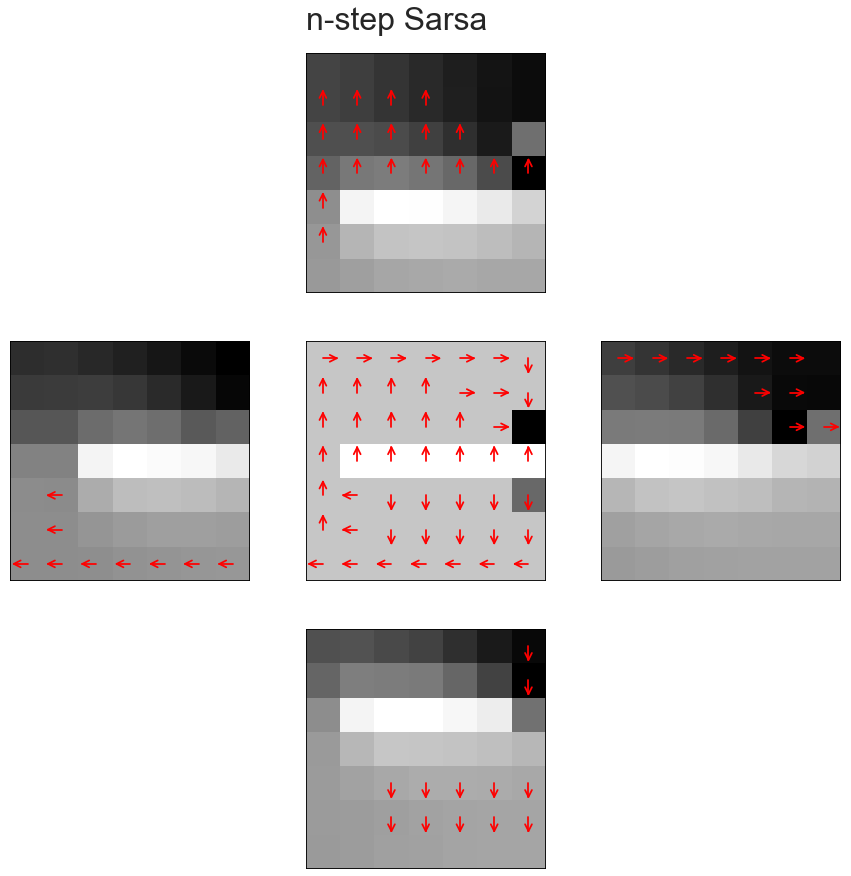

In [336]:
horizon = 4
Q = np.zeros((SIZE_Y, SIZE_X, len(ACTION_SPACE)))

for episode in range(1, NUM_GAMES+1):
    state = tuple(map(int, np.where(WORLD==1)))
    action = policy(Q, state, EPSIL)
    S, A, R = [state], [action], [0]
    
    step = 0
    terminal = float("inf")
    
    while True:
        if step < terminal:
            move = direction(state, ACTION_SPACE[action])
            next_s = move if is_legal(move) else state
            
            S.append(next_s)
            R.append(REWARD[WORLD[next_s]])
            
            if next_s == np.where(WORLD==2):
                terminal = step +1
            else:
                next_a = policy(Q, next_s, EPSIL)
                A.append(next_a)
                
            state, action = next_s, next_a
            
        tau = step - horizon + 1
        if tau >= 0:
            expected = sum(
                GAMMA **(i-tau-1) * R[i] 
                for i in range(tau+1, min(tau+horizon, terminal))
            )
            
            if tau + horizon < terminal:
                expected += GAMMA **horizon *Q[S[tau+horizon]][A[tau+horizon]]
            Q[S[tau]][A[tau]] += ALPHA * (expected - Q[S[tau]][A[tau]])
        
        if tau == terminal - 1: break
        step += 1
        
    if episode % (NUM_GAMES//10) == 0:
        print(f"State-action value optimization is {episode / NUM_GAMES:.0%} done.")
        
detailed_quality_check(state_action_value, "n-step Sarsa", allowed=[-1,0,1])

# Off-policy n-step Sarsa for estimating $Q\approx q_*$ or $q_\pi$

Reinforcement Learning: An Introduction 7.3: n-step off-policy learning (page 149)

In [28]:
def importance_sample_ratio(Q:np.ndarray, state:tuple, action:int, eps=0.5):
    """ Zero IF behaviour action is NOT greedy ELSE ratio prob_pi(1) / prob_b """
    if action != policy(Q, state, 0): return 0
    return 1 / (1-eps+(eps/len(ACTION_SPACE)))

State-action value optimization is 10% done.
State-action value optimization is 20% done.
State-action value optimization is 30% done.
State-action value optimization is 40% done.
State-action value optimization is 50% done.
State-action value optimization is 60% done.
State-action value optimization is 70% done.
State-action value optimization is 80% done.
State-action value optimization is 90% done.
State-action value optimization is 100% done.


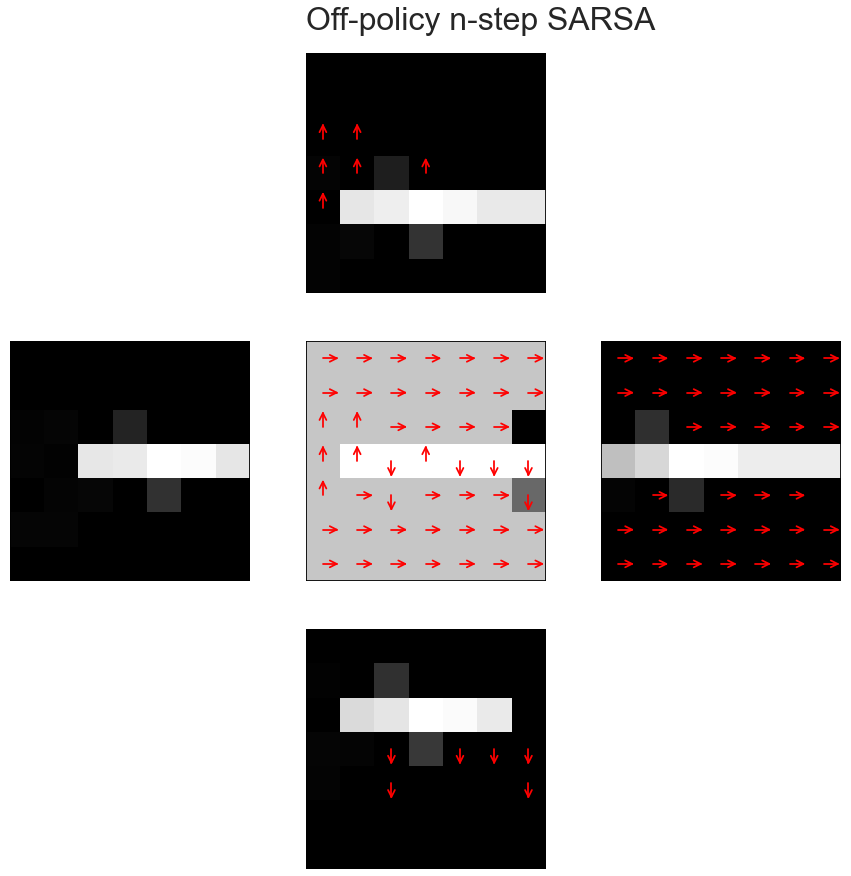

In [340]:
horizon = 4

Q = np.zeros((SIZE_Y, SIZE_X, len(ACTION_SPACE)))

for episode in range(1, NUM_GAMES+1):
    state = tuple(map(int, np.where(WORLD==1)))
    action = policy(state_action_value, state, EPSIL)
    S, A, R = [state], [action], [0]
    
    step = 0
    terminal = float("inf")
    
    while True:
        if step < terminal:
            move = direction(state, ACTION_SPACE[action])
            next_s = move if is_legal(move) else state
            S.append(next_s)
            R.append(REWARD[WORLD[next_s]])

            if next_s == np.where(WORLD==2):
                terminal = step +1
            else:
                next_a = policy(Q, next_s)
                A.append(next_a)

            state, action = next_s, next_a
        
        tau = step - horizon + 1
        if tau >= 0:
            probability = math.prod(
                importance_sample_ratio(Q, S[i], A[i], EPSIL)
                for i in range(tau+1, min(tau+horizon, terminal))
            )
            expected = sum(
                GAMMA **(i-tau-1) *R[i] 
                for i in range(tau+1, min(tau+horizon, terminal))
            )

            if tau + horizon < terminal:
                expected += GAMMA **horizon *Q[S[tau+horizon]][A[tau+horizon]]
            Q[S[tau]][A[tau]] += (ALPHA * probability)*(expected - Q[S[tau]][A[tau]])

        if tau == terminal - 1: break
        step += 1
        
    if episode % (NUM_GAMES//10) == 0:
        print(f"State-action value optimization is {episode / NUM_GAMES:.0%} done.")
        
detailed_quality_check(Q, "Off-policy n-step SARSA", allowed=[-1,0,1])

# N-step Tree Backup for estimation $Q\approx q_*$ or $q_\pi$

Reinforcement Learning: An Introduction 7.5: Off-policy Learning Without Importance Sampling: n-step Tree Backup (page 154)

In [341]:
def action_probability(Q:np.ndarray, action: int, state:tuple, epsilon=0.0) -> float:
    """ Probability of the action being chosen by the policy"""
    if epsilon == 0:
        return 1 if action == policy(Q, state, epsilon) else 0
    else:
        """ Further research """
        pass

State-action value optimization is 10% done.
State-action value optimization is 20% done.
State-action value optimization is 30% done.
State-action value optimization is 40% done.
State-action value optimization is 50% done.
State-action value optimization is 60% done.
State-action value optimization is 70% done.
State-action value optimization is 80% done.
State-action value optimization is 90% done.
State-action value optimization is 100% done.


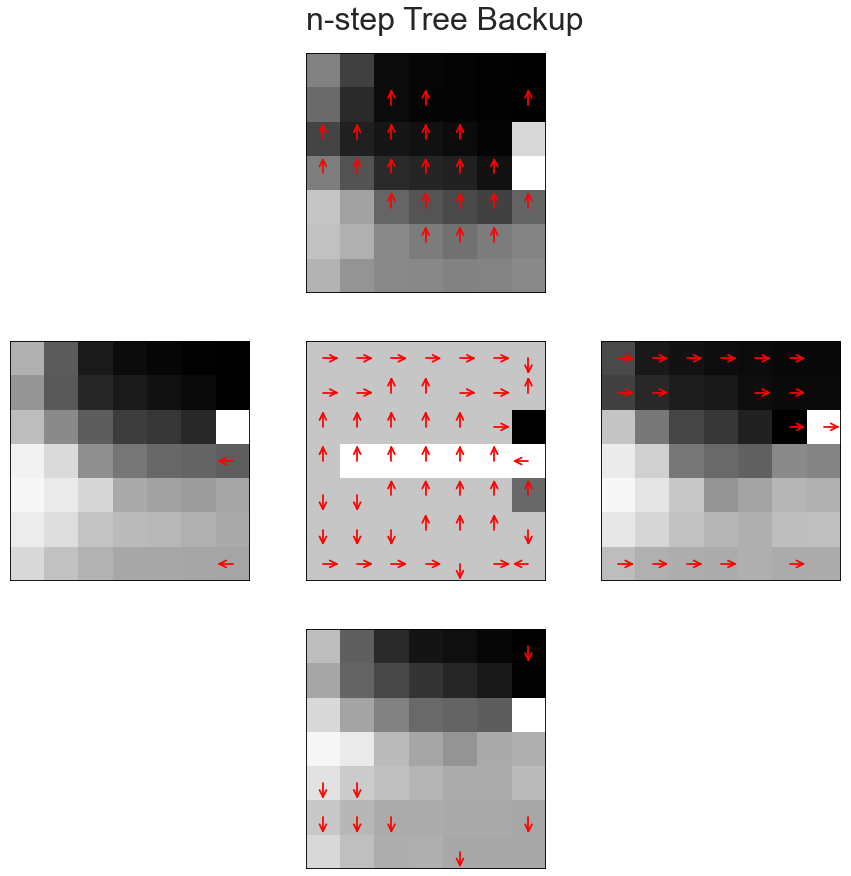

In [343]:
horizon = 4

Q = np.zeros((SIZE_Y, SIZE_X, len(ACTION_SPACE)))

for episode in range(1, NUM_GAMES+1):
    state = tuple(map(int, np.where(WORLD==1)))
    action = policy(state_action_value, state, EPSIL)
    S, A, R = [state], [action], [0]
    
    step = 0
    terminal = float("inf")
    
    while True:
        if step < terminal:
            move = direction(state, ACTION_SPACE[action])
            next_s = move if is_legal(move) else state
            S.append(next_s)
            R.append(REWARD[WORLD[next_s]])

            if next_s == np.where(WORLD==2):
                terminal = step +1
            else:
                next_a = policy(Q, next_s, EPSIL)
                A.append(next_a)

            state, action = next_s, next_a
            
        tau = step - horizon + 1
        if tau >= 0:
            if step + 1 >= terminal:
                expected = R[terminal]
            else:
                expected = R[step+1] + GAMMA * sum(
                    action_probability(Q, a, S[step+1]) * Q[S[step+1]][a]
                    for a in ACTION_SPACE
                )
             
            for k in range(min(step, terminal-1), tau+1):
                expected = R[k] + GAMMA * sum(
                    action_probability(Q, a, S[k]) * Q[S[k]][a]
                    for a in ACTION_SPACE 
                    if a != A[k]
                ) + GAMMA * action_probability(Q, A[k], S[k]) * expected
                
            Q[S[tau]][A[tau]] += ALPHA * (expected - Q[S[tau]][A[tau]])
            
        if tau == terminal - 1: break
        step += 1
        
    if episode % (NUM_GAMES//10) == 0:
        print(f"State-action value optimization is {episode / NUM_GAMES:.0%} done.")
        
detailed_quality_check(Q, "n-step Tree Backup", allowed=[-1,0,1])

# Off-policy n-step $Q(\sigma)$ for estimating $Q\approx q_*$ or $q_\pi$

Reinforcement Learning: An Introduction 7.6: A Unifying Algorithm: n-step $Q(\sigma)$ (page 156)

State-action value optimization is 10% done.
State-action value optimization is 20% done.
State-action value optimization is 30% done.
State-action value optimization is 40% done.
State-action value optimization is 50% done.
State-action value optimization is 60% done.
State-action value optimization is 70% done.
State-action value optimization is 80% done.
State-action value optimization is 90% done.
State-action value optimization is 100% done.


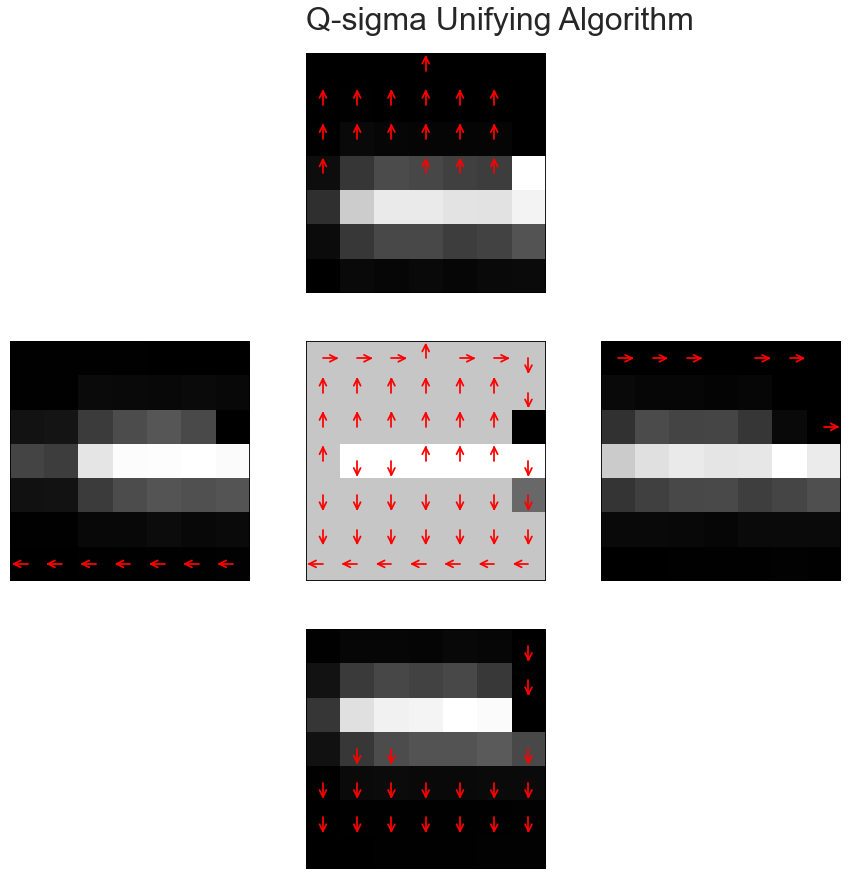

In [356]:
horizon = 4

Q = np.zeros((SIZE_Y, SIZE_X, len(ACTION_SPACE)))

for episode in range(1, NUM_GAMES+1):
    state = tuple(map(int, np.where(WORLD==1)))
    action = policy(state_action_value, state, EPSIL)
    
    S, A, R = [state], [action], [0]
    sigmas, ratios = [1], [0]
    
    step = 0
    terminal = float("inf")
    
    while True:
        if step < terminal:
            move = direction(state, ACTION_SPACE[action])
            next_s = move if is_legal(move) else state
            S.append(next_s)
            R.append(REWARD[WORLD[next_s]])
            
            if next_s == np.where(WORLD==2):
                terminal = step +1
            else:
                next_a = policy(Q, next_s)
                A.append(next_a)
                
                sigmas.append((step+1) % 2)
                ratios.append(importance_sample_ratio(Q, next_s, next_a, EPSIL))
                
            state, action = next_s, next_a
            
        tau = step - horizon + 1
        if tau >= 0:
            if step + 1 < terminal:
                expected = Q[S[step+1]][A[step+1]]
                
            for k in range(tau+1, min(step+1, terminal)):
                if k == terminal:
                    expected = R[terminal]
                else:
                    value = sum(
                        action_probability(Q, a, S[k]) *Q[S[k]][a]
                        for a in ACTION_SPACE
                    )
                    
                    expected = R[k] + GAMMA * (
                        sigmas[k]*ratios[k] + (1-sigmas[k]) *action_probability(Q, A[k], S[k])
                    ) * (expected - Q[S[k]][A[k]]) + GAMMA *value
                    
            Q[S[tau]][A[tau]] += ALPHA * (expected - Q[S[tau]][A[tau]])
        
        if tau == terminal - 1: break
        step += 1
        
    if episode % (NUM_GAMES//10) == 0:
        print(f"State-action value optimization is {episode / NUM_GAMES:.0%} done.")
        
detailed_quality_check(Q, "Q-sigma Unifying Algorithm", allowed=[-1,0,1]

# Need to find a more efficient memory object so I can train faster and more